In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [58]:
factorReduce = 3

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // pow(2, factorReduce)),
            nn.ReLU(),
            nn.Linear(input_dim // pow(2, factorReduce), input_dim // pow(2, factorReduce + 1)),
            nn.ReLU(),
            nn.Linear(input_dim // pow(2, factorReduce + 1), input_dim // pow(2, factorReduce + 2)),
            nn.ReLU(),
            nn.Linear(input_dim // pow(2, factorReduce + 2), input_dim // pow(2, factorReduce + 3))
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // pow(2, factorReduce + 3), input_dim // pow(2, factorReduce + 2)),
            nn.ReLU(),
            nn.Linear(input_dim // pow(2, factorReduce + 2), input_dim // pow(2, factorReduce + 1)),
            nn.ReLU(),
            nn.Linear(input_dim // pow(2, factorReduce + 1), input_dim // pow(2, factorReduce)),
            nn.ReLU(),
            nn.Linear(input_dim // pow(2, factorReduce), input_dim)
        )
    
    def numParams(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


In [91]:
# For ADeX info:
import os
files = os.listdir("./data")

content = []
genes = []
people_ids = []
for file in files:
    # Read through file + add the data
    lines = open(f"./data/{file}", "r").readlines()
    for people in lines[0].split("\t"):
        people_ids.append(people)
    gene_list = []
    for line in lines[1:]:
        line_split = line.split("\t")
        gene_list.append(line_split[0])
        content_line = [float(x.replace("\"", "")) for x in line_split[1:]]
        content.append(content_line)
    genes = gene_list
    break

print(content[-1])
content = np.array(content, float)
data = content[:65].T

print(f"Summary:\n\tNumber of Genes: {len(genes)}\n\tNumber of samples: {len(people_ids)}")

[7.00259331593224, 6.1071412981647, 7.24833860800845, 6.95163861897049, 6.04487840103632, 6.31659292623788, 6.53029236276327, 6.35169448757607, 7.48564482093312, 6.59395070584167, 7.00901084729816, 7.40402835493008, 6.76834740180673, 6.83820969043376, 6.70637101689484, 6.6882588781176, 6.40010275603468, 6.31992758052761, 5.99981168970223, 6.26205209965701, 6.61081232483808, 6.86675195176869]
Summary:
	Number of Genes: 13892
	Number of samples: 23


In [ ]:
# For GeneExpressionData.txt:
content = []
people = []
genes = []
for line in open("./GeneExpressionData.txt", "r"):
    if not people:
        people = line.split("\t")[1:]
    else:
        line_split = line.split("\t")
        genes.append(line_split[0])
        content.append([float(x) for x in line_split[1:]])

content = np.array(content, float)
data = content[:65].T

genes[10:], content[10:], people[10:]

(['"ENSG00000001460_STPG1"',
  '"ENSG00000001461_NIPAL3"',
  '"ENSG00000001497_LAS1L"',
  '"ENSG00000001561_ENPP4"',
  '"ENSG00000001617_SEMA3F"',
  '"ENSG00000001626_CFTR"',
  '"ENSG00000001629_ANKIB1"',
  '"ENSG00000001630_CYP51A1"',
  '"ENSG00000001631_KRIT1"',
  '"ENSG00000002016_RAD52"',
  '"ENSG00000002079_MYH16"',
  '"ENSG00000002330_BAD"',
  '"ENSG00000002549_LAP3"',
  '"ENSG00000002586_CD99"',
  '"ENSG00000002587_HS3ST1"',
  '"ENSG00000002726_AOC1"',
  '"ENSG00000002745_WNT16"',
  '"ENSG00000002746_HECW1"',
  '"ENSG00000002822_MAD1L1"',
  '"ENSG00000002834_LASP1"',
  '"ENSG00000002919_SNX11"',
  '"ENSG00000002933_TMEM176A"',
  '"ENSG00000003056_M6PR"',
  '"ENSG00000003096_KLHL13"',
  '"ENSG00000003137_CYP26B1"',
  '"ENSG00000003147_ICA1"',
  '"ENSG00000003249_DBNDD1"',
  '"ENSG00000003393_ALS2"',
  '"ENSG00000003400_CASP10"',
  '"ENSG00000003402_CFLAR"',
  '"ENSG00000003436_TFPI"',
  '"ENSG00000003509_NDUFAF7"',
  '"ENSG00000003756_RBM5"',
  '"ENSG00000003987_MTMR7"',
  '"ENSG

In [92]:
# Simulated gene expression data
np.random.seed(42)
 # np.random.rand(num_samples, z).astype(np.float32)
z = len(data[0])  # Number of genes
num_samples = len(data)

# Convert to PyTorch tensors and create DataLoader
tensor_data = torch.tensor(data)
dataset = TensorDataset(tensor_data)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

input_dim = z
model = Autoencoder(input_dim)

z, num_samples, model.numParams()

(65, 22, 1218)

In [93]:
def reconstruction_accuracy(original, reconstructed, tolerance=0.1):
    within_tolerance = torch.abs(original - reconstructed) <= tolerance
    accuracy = within_tolerance.float().mean().item()
    return accuracy

In [96]:
# Initialize the model, loss function, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    total_loss = 0
    total_accuracy = 0
    batches = 0
    for (inputs,) in data_loader:
        inputs = inputs.float()
        # Forward pass
        reconstructed, _ = model(inputs)
        loss = criterion(reconstructed, inputs)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += reconstruction_accuracy(inputs, reconstructed)
        batches += 1
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}\n\tAccuracy: {round(total_accuracy * 100/batches)}%")
    if total_loss / len(data_loader) <= 0.01:
        break


Epoch 1/10000, Loss: 5.1299
	Accuracy: 3%
Epoch 2/10000, Loss: 3.2019
	Accuracy: 7%
Epoch 3/10000, Loss: 2.1659
	Accuracy: 9%
Epoch 4/10000, Loss: 1.3399
	Accuracy: 10%
Epoch 5/10000, Loss: 0.9471
	Accuracy: 12%
Epoch 6/10000, Loss: 0.6085
	Accuracy: 13%
Epoch 7/10000, Loss: 0.5060
	Accuracy: 14%
Epoch 8/10000, Loss: 0.3243
	Accuracy: 16%
Epoch 9/10000, Loss: 0.3414
	Accuracy: 16%
Epoch 10/10000, Loss: 0.2416
	Accuracy: 17%
Epoch 11/10000, Loss: 0.2925
	Accuracy: 15%
Epoch 12/10000, Loss: 0.2036
	Accuracy: 23%
Epoch 13/10000, Loss: 0.2099
	Accuracy: 19%
Epoch 14/10000, Loss: 0.1853
	Accuracy: 21%
Epoch 15/10000, Loss: 0.1687
	Accuracy: 24%
Epoch 16/10000, Loss: 0.1530
	Accuracy: 23%
Epoch 17/10000, Loss: 0.1200
	Accuracy: 26%
Epoch 18/10000, Loss: 0.1198
	Accuracy: 26%
Epoch 19/10000, Loss: 0.0938
	Accuracy: 28%
Epoch 20/10000, Loss: 0.1021
	Accuracy: 27%
Epoch 21/10000, Loss: 0.0795
	Accuracy: 33%
Epoch 22/10000, Loss: 0.0877
	Accuracy: 31%
Epoch 23/10000, Loss: 0.0809
	Accuracy: 32%


KeyboardInterrupt: 

In [97]:
# Encode the data to latent space
latent_features = []
model.eval()
with torch.no_grad():
    for batch in data_loader:
        inputs = batch[0]
        inputs = inputs.float()
        output, latent = model(inputs)
        print("Input, latent", latent, output)
        latent_features.append(latent.numpy())

latent_features = np.concatenate(latent_features, axis=0)
print("Latent features shape:", latent_features.shape)
latent_features

Input, latent tensor([[-7.6337],
        [-7.6943],
        [-7.6589],
        [-7.6697],
        [-7.7366],
        [-7.7107],
        [-7.6928],
        [-7.6239],
        [-7.6582],
        [-7.5899],
        [-7.4818],
        [-7.5701],
        [-7.6458],
        [-7.5358],
        [-7.6784],
        [-7.6377]]) tensor([[ 6.4785,  6.7058,  6.1792,  ..., 10.9351,  7.7560,  9.8307],
        [ 6.5109,  6.7364,  6.2053,  ..., 10.9853,  7.7947,  9.8777],
        [ 6.4919,  6.7185,  6.1901,  ..., 10.9560,  7.7721,  9.8502],
        ...,
        [ 6.4262,  6.6562,  6.1371,  ..., 10.8541,  7.6935,  9.7548],
        [ 6.5023,  6.7283,  6.1984,  ..., 10.9721,  7.7845,  9.8653],
        [ 6.4806,  6.7078,  6.1809,  ..., 10.9384,  7.7585,  9.8338]])
Input, latent tensor([[-7.7214],
        [-7.6672],
        [-7.6965],
        [-7.6646],
        [-7.6268],
        [-7.6606]]) tensor([[ 6.5253,  6.7501,  6.2169,  5.3650,  6.2835,  5.1088,  9.8568,  5.6461,
          7.0820,  7.5505,  7.0717,  

array([[-7.6336946],
       [-7.6943293],
       [-7.6588807],
       [-7.669742 ],
       [-7.7365613],
       [-7.71068  ],
       [-7.6928005],
       [-7.623912 ],
       [-7.658159 ],
       [-7.5898747],
       [-7.481755 ],
       [-7.570144 ],
       [-7.6458435],
       [-7.5357656],
       [-7.678365 ],
       [-7.6376805],
       [-7.721365 ],
       [-7.6671586],
       [-7.696532 ],
       [-7.6645794],
       [-7.626802 ],
       [-7.660613 ]], dtype=float32)

In [101]:
for i, person in enumerate(people_ids[1:]):
    print(i, person)

0 "GSM260886"
1 "GSM260889"
2 "GSM260891"
3 "GSM260894"
4 "GSM260897"
5 "GSM260900"
6 "GSM260903"
7 "GSM260906"
8 "GSM260909"
9 "GSM260914"
10 "GSM260916"
11 "GSM260919"
12 "GSM260922"
13 "GSM260925"
14 "GSM260927"
15 "GSM260930"
16 "GSM260933"
17 "GSM260936"
18 "GSM260939"
19 "GSM260942"
20 "GSM260945"
21 "GSM260950"



[-7.6336946, -7.6943293, -7.6588807, -7.669742, -7.7365613, -7.71068, -7.6928005, -7.623912, -7.658159] [-7.5898747, -7.481755, -7.570144, -7.6458435, -7.5357656, -7.678365, -7.6376805, -7.721365, -7.6671586, -7.696532, -7.6645794, -7.626802]


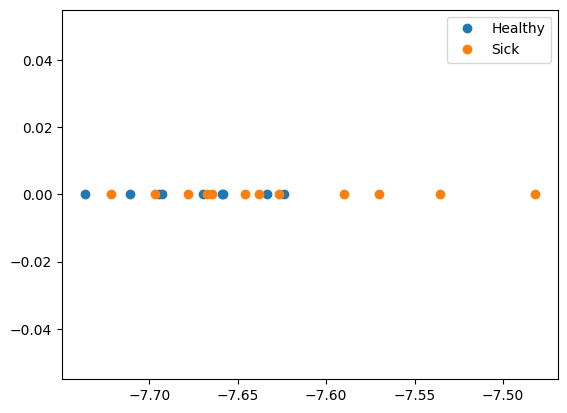

In [111]:
results = []
healthyNums = []
sleNums = []
lines = open("./metadata.tsv").readlines()
for i, info in enumerate(lines[1:len(latent_features)]):
    res = info.split("\t")[4]
    results.append(res)
    if res == "Healthy":
        healthyNums.append(latent_features[i][0])
    else:
        sleNums.append(latent_features[i][0])

print(healthyNums, sleNums)
plt.plot(healthyNums, [0 for x in range(len(healthyNums))], 'o', label="Healthy")
plt.plot(sleNums, [0 for x in range(len(sleNums))], 'o', label="Sick")
plt.legend()
plt.show()

In [68]:
# Perform t-SNE on latent features
tsne = TSNE(n_components=2, perplexity=len(data)-1, random_state=42)
latent_2d = tsne.fit_transform(latent_features)

# Plot the t-SNE results
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.7)
plt.title("t-SNE Visualization of Latent Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'

In [ ]:
# Replace this with loading real gene expression data
data = np.load("path_to_gene_expression_data.npy")  # Replace with your dataset file
